In [2]:
import ase
import abtem

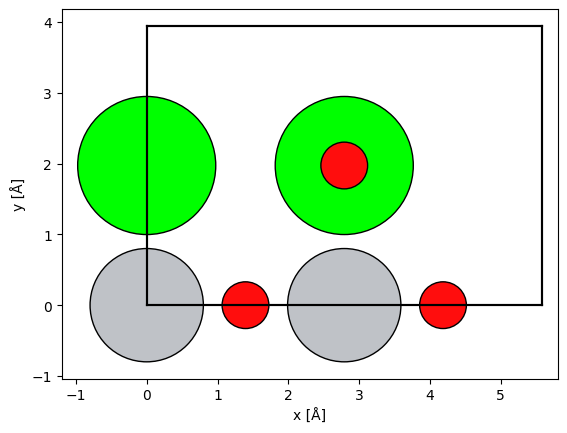

In [3]:
srtio3 = ase.io.read("data/SrTiO3.cif")

srtio3_110 = ase.build.surface(srtio3, indices=(1, 1, 0), layers=2, periodic=True)

srtio3_110.translate((0, srtio3_110.cell.lengths()[1] / 2, 0))

srtio3_110.wrap()

abtem.show_atoms(srtio3_110, plane="xy", scale=0.5);

/home/wdekleijne/GitRepos2/electron-scattering-simulations-tutorial/.venv/lib/python3.11/site-packages/ase/io/cif.py:836: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


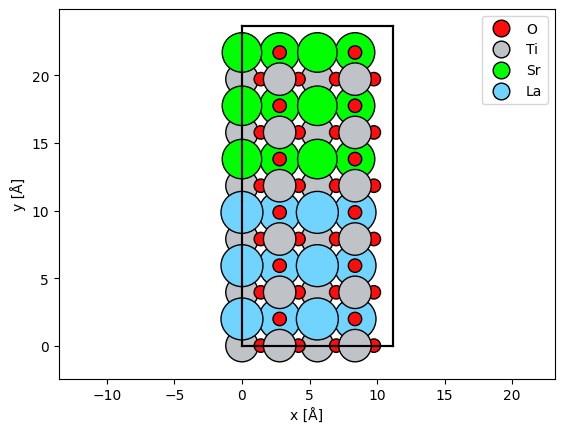

In [4]:
repeated_srtio3 = srtio3_110 * (2, 6, 4)

sto_lto_interface = repeated_srtio3.copy()

# select atoms with atomic number 38
mask_sr = sto_lto_interface.numbers == 38

# select atoms below the center
mask_below = sto_lto_interface.positions[:, 1] < sto_lto_interface.cell[1, 1] / 2

# combine selection
mask_combined = mask_sr * mask_below

# assign new atomic numbers to selection
sto_lto_interface.numbers[mask_combined] = 57

ase.io.write("./data/STO_LTO.cif", sto_lto_interface)

abtem.show_atoms(sto_lto_interface, legend=True);

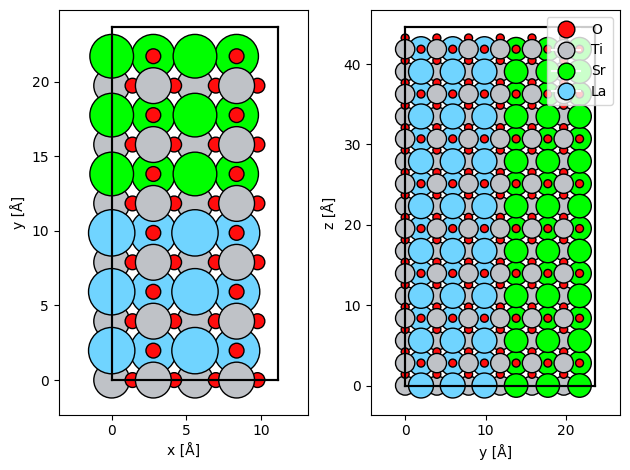

In [5]:
import matplotlib.pyplot as plt
import ase.io

atoms = ase.io.read("./data/STO_LTO.cif")

atoms = atoms * (1, 1, 2)

potential = abtem.Potential(atoms, gpts=(512, 512))

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(atoms, ax=ax1)
abtem.show_atoms(atoms, legend=True, ax=ax2, plane="yz")
plt.tight_layout()

In [6]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
)

In [7]:
s_matrix_array = s_matrix.build()

s_matrix_array.compute()

[########################################] | 100% Completed | 37.03 ss


In [8]:
waves = s_matrix_array.waves[:100:20].compute()

In [9]:
# waves = s_matrix_array.waves.compute()
print(waves.shape)  # (n_depth, n_beam, n_wave)

(5, 160, 342)


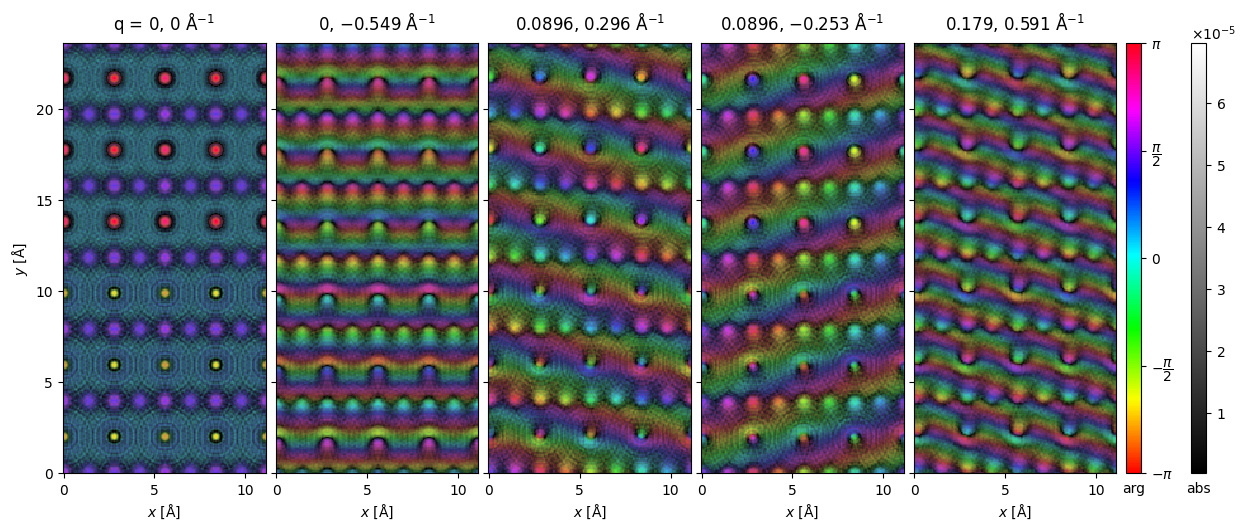

In [10]:
visualization = waves.to_images().show(
    explode=True, figsize=(16, 5), cmap="hsv", cbar=True, common_color_scale=True
);

In [11]:
sampling = abtem.transfer.nyquist_sampling(s_matrix.semiangle_cutoff, s_matrix.energy)

scan = abtem.GridScan(
    start=(0, 0),
    end=(1, 1),
    fractional=True,
    potential=potential,
    sampling=sampling,
)

print(f"Number of probe positions: {len(scan)}")
print(f"Number of plane waves: {len(s_matrix)}")
print(f"Ratio: {len(scan) / len(s_matrix):.1f}")

Number of probe positions: 2015
Number of plane waves: 425
Ratio: 4.7


In [12]:
detector = abtem.AnnularDetector(inner=50, outer=150)

measurement = s_matrix.scan(scan=scan, detectors=detector).compute()

[########################################] | 100% Completed | 41.99 ss


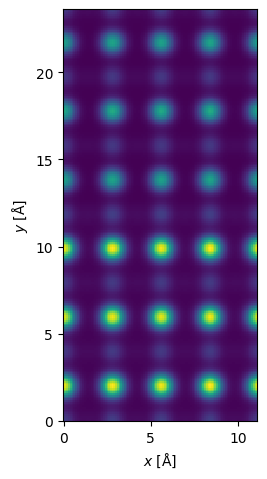

In [13]:
interpolated_measurement = measurement.interpolate(0.1).gaussian_filter(0.3)

interpolated_measurement.show();

In [23]:
s_matrix_non_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(1, 1),
)
s_matrix_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(1, 2),
)

s_matrix_more_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(2, 4),
)

s_matrix_very_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(4, 8),
)

In [24]:
measurement_non_interpolated = s_matrix_non_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()
measurement_interpolated = s_matrix_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()
measurement_more_interpolated = s_matrix_more_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()
measurement_very_interpolated = s_matrix_very_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()

[########################################] | 100% Completed | 39.01 ss
[########################################] | 100% Completed | 21.35 ss
[########################################] | 100% Completed | 10.69 s
[########################################] | 100% Completed | 5.09 ss


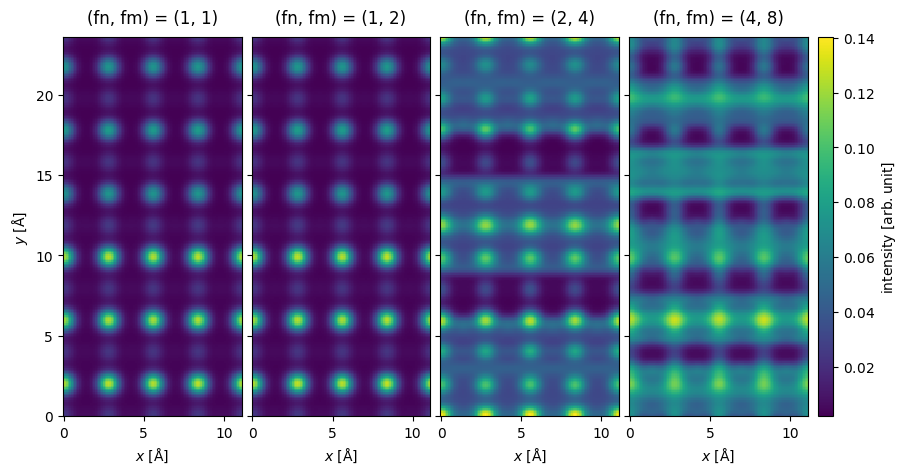

In [16]:
interpolated_measurements = (
    abtem.stack(
        [
            measurement,
            measurement_interpolated,
            measurement_more_interpolated,
            measurement_very_interpolated,
        ],
        (
            "(fn, fm) = (1, 1)",
            "(fn, fm) = (1, 2)",
            "(fn, fm) = (2, 4)",
            "(fn, fm) = (4, 8)",
        ),
    )
    .interpolate(0.1)
    .gaussian_filter(0.3)
)

interpolated_measurements.show(
    explode=True,
    figsize=(10, 6),
    common_color_scale=True,
    cbar=True,
);

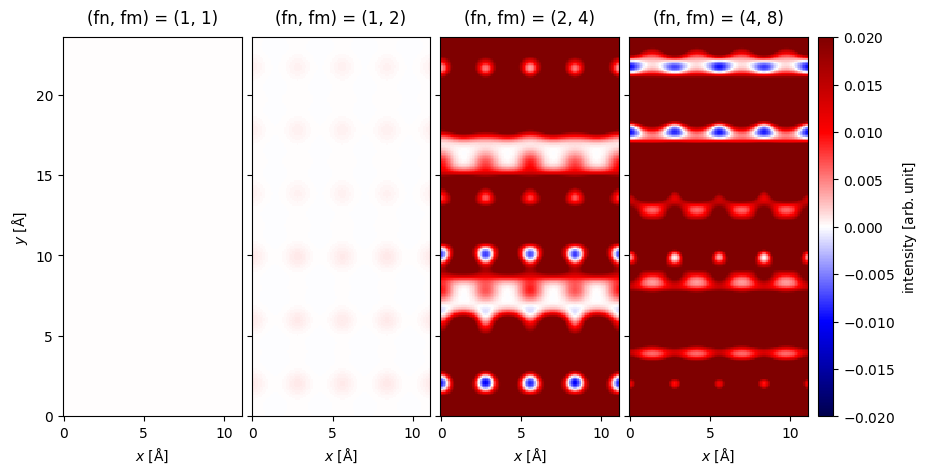

In [17]:
errors = abtem.stack(
    [
        interpolated_measurements[0] - interpolated_measurement,
        interpolated_measurements[1] - interpolated_measurement,
        interpolated_measurements[2] - interpolated_measurement,
        interpolated_measurements[3] - interpolated_measurement,
    ],
    (
        "(fn, fm) = (1, 1)",
        "(fn, fm) = (1, 2)",
        "(fn, fm) = (2, 4)",
        "(fn, fm) = (4, 8)",
    ),
)


visualization = (
    errors.gaussian_filter(0.3)
    .interpolate(0.1)
    .show(
        explode=True,
        figsize=(10, 6),
        common_color_scale=True,
        cbar=True,
        cmap="seismic",
        vmin=-0.02,
        vmax=0.02,
    )
);

[########################################] | 100% Completed | 101.70 ms
[########################################] | 100% Completed | 207.14 ms
[########################################] | 100% Completed | 203.46 ms
[########################################] | 100% Completed | 102.01 ms


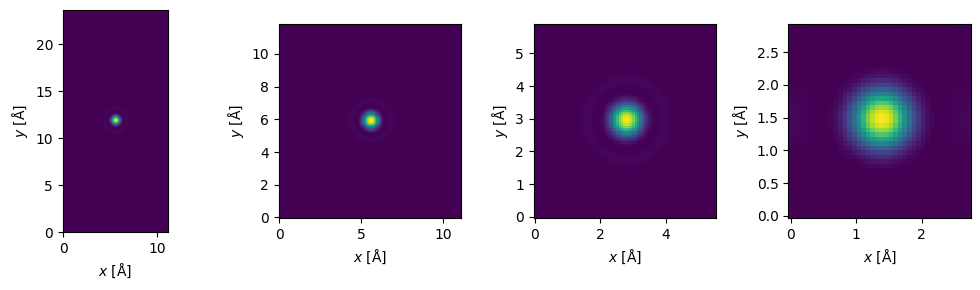

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

s_matrix.dummy_probes().show(ax=ax1)

s_matrix_interpolated.dummy_probes().show(ax=ax2)

s_matrix_more_interpolated.dummy_probes().show(ax=ax3)

s_matrix_very_interpolated.dummy_probes().show(ax=ax4)

plt.tight_layout();

In [19]:
import numpy as np
defocus = -np.linspace(0, 80, 5)

ctf = abtem.CTF(defocus=defocus)

measurement_with_aberrations = s_matrix_interpolated.scan(
    scan=scan, detectors=detector, ctf=ctf
).compute()

measurement_with_aberrations = measurement_with_aberrations.interpolate(0.1).gaussian_filter(0.3).compute()

[########################################] | 100% Completed | 34.04 ss


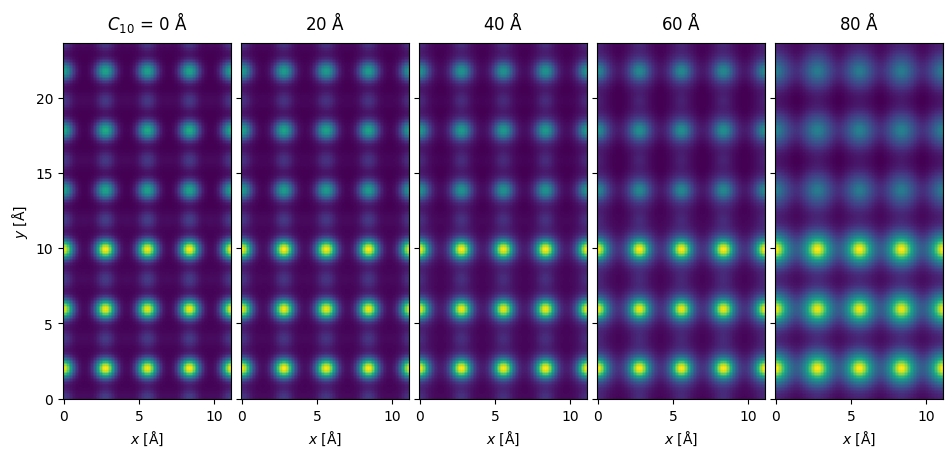

In [20]:
measurement_with_aberrations.show(
    explode=True,
    figsize=(10, 6),
);

In [21]:
measurement = s_matrix.scan(
    scan=scan, detectors=detector, max_batch_multislice = 20, max_batch_reduction = 200
)

In [22]:
import dask
dask.config.set({"distributed.scheduler.worker-saturation" : 1.1})